## 3.1 - Data Exploratory Data Analysis (EDA)
Prior to jumping into modeling and running the algorithms, it is best to get a handle on the data. EDA is generally is visualizing, running statistics to understand the various features, data types within each feature and even between features and labels.

For this there are few areas that I'll document here that impacted the EDA and modeling. For each of the concerns, the sections that follow discuss some of the decisions made and approach for prepping the data for final modeling.
- 3.1.1 - multi-class vs. binary classifcation
- 3.1.1 - feature and label correlation
- 3.1.2 - normalization and scaling feature data - TODO
- 3.1.3 - linear separability of data - TODO


In [1]:
#this is for development only and not relevant
%load_ext autoreload
%autoreload

In [2]:
# First lets pull and load up Pandas data frames as follows:
# df_red - just the red wine
# df_white - just the white wine
# df_all -- both red and white in the same data frame.

# NOTE: if the file already exists, we skip the downoad from an internet
#       location. The force flag allows overriding that behavior.

from utils.helpers import *
df_red, df_white, df_all = pull_and_load_data(force = False)

path exist and not forced
path exist and not forced


### 3.1.1 - Class Analysis - multi-class vs. binary classifcation
For this analysis I only use the combined dataset of red and white wine. You will see shortly as to why this may not matter **much** - I emphasize that this is something for further analsys in the future. However, my own experimentation showed little impact of the difference between white or red with only a few points difference in accuracy of the model. So, in short, you'll see the `df_all` data set - the combined dataset - as the primary corpus for this report.

### 3.1.1 - Categories of Labels
First we look at the category of labels and do a quick analysis on the data. The first visualization is a pairwise correlation for feature + labels. This generates a correlation matrix that can be shown using a Seaborn Heatmap that emphasizes stronger correlations, either negative or positive, for combination of feature or label. Again this capability is built into Pandas using the [DataFrame.corr()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) function and Seaborn's Heatmap function [seaborn.heatmap()](https://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap).

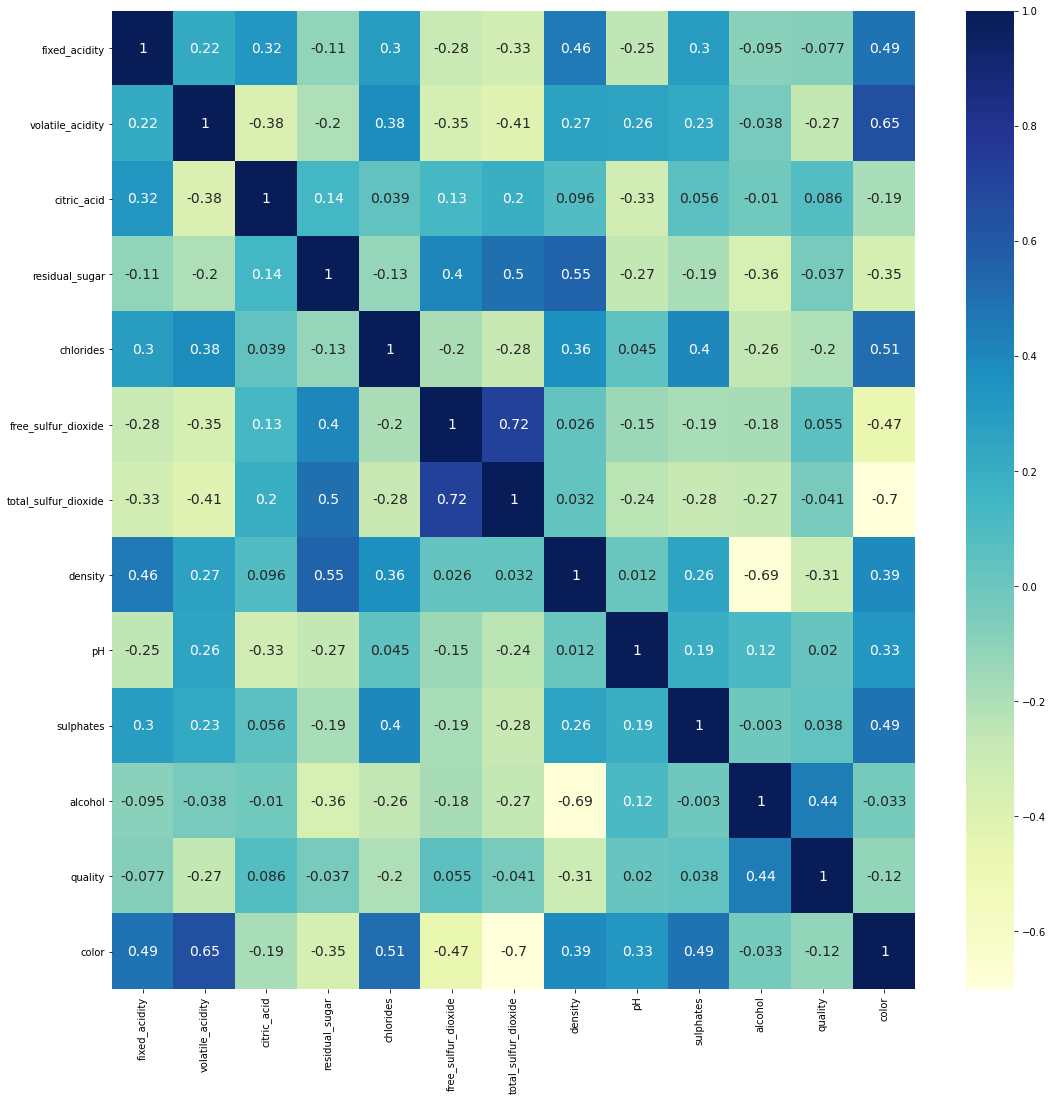

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

figsize = 18, 18
plt.figure(figsize = figsize)
rv = df_all.corr()
sns.heatmap(rv, annot = True, annot_kws = {"size": 14}, cmap = "YlGnBu") # Blues, Blues_r YlGnBu
plt.show()

#### 3.1.1.1 - Feature importance
From the heatmap above, and the summary of the pairwise correlation below, we can see taht **color**, while not zero, has some impact on the quality - the value of `-0.12` in the overall order below, which is absolute value of each **quality vs feature** is in the middle. 

Since I'm not interested in determnining strictly either White or Red predictability, the future data sets will remove that column in order to just focus on the remaining features and the label.

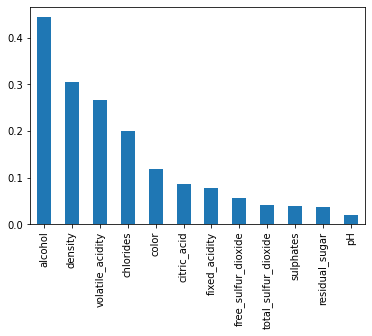

> Ordered Correlation result: {}

alcohol                 0.444319
density                 0.305858
volatile_acidity        0.265699
chlorides               0.200666
color                   0.119323
citric_acid             0.085532
fixed_acidity           0.076743
free_sulfur_dioxide     0.055463
total_sulfur_dioxide    0.041385
sulphates               0.038485
residual_sugar          0.036980
pH                      0.019506
Name: quality, dtype: float64


In [4]:
# this gives us a sigle series of the quality vs features absolute
# value sorted descending. The higher the number (abs) the greater the correlation.
ordered_corr = df_all.corr().loc['quality'].abs().sort_values(ascending=False)[1:]

ordered_corr.plot.bar()
plt.show()

emit_md('> Ordered Correlation result: {}')
print(ordered_corr)

#### 3.1.1.2 - Dropping Color
Now take a look at the same red & white wine data without color using the same heatmap and sort of correlation.


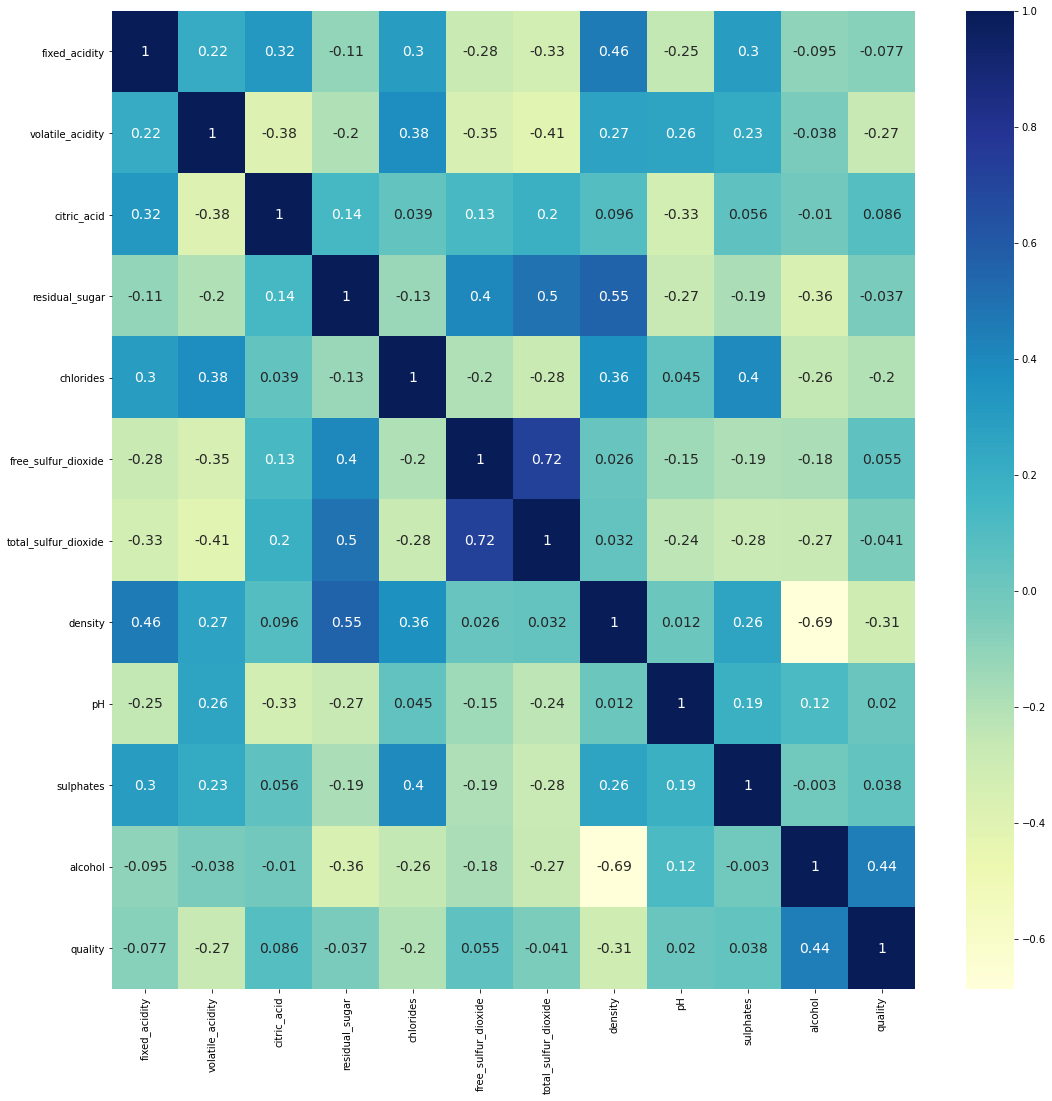

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# for is I will drop the color column that was added initially.
# we probably don't need the color given the correlation to
# quality was relatively 'low'

df_no_color = get_df_no_color(df_all)

figsize = 18, 18
plt.figure(figsize = figsize)
rv = df_no_color.corr()
sns.heatmap(rv, annot = True, annot_kws = {"size": 14}, label = "foo", cmap = "YlGnBu") # Blues, Blues_r YlGnBu
plt.show()

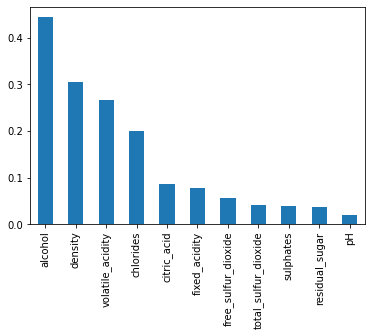

> Ordered Correlation result: {}

alcohol                 0.444319
density                 0.305858
volatile_acidity        0.265699
chlorides               0.200666
citric_acid             0.085532
fixed_acidity           0.076743
free_sulfur_dioxide     0.055463
total_sulfur_dioxide    0.041385
sulphates               0.038485
residual_sugar          0.036980
pH                      0.019506
Name: quality, dtype: float64


In [6]:
# this gives us a sigle series of the quality vs features absolute
# value sorted descending. The higher the number (abs) the greater the correlation.
ordered_corr = df_no_color.corr().loc['quality'].abs().sort_values(ascending=False)[1:]

ordered_corr.plot.bar()
plt.show()
emit_md('> Ordered Correlation result: {}')
print(ordered_corr)

#### 3.1.1.3 - Collapsing Classes
So far, while there's has been quite a bit of analysis on impact of all the features, the focus initially was on the removing the **color** feature from our combined data set of red and white wines. Recall that the goal for **THIS** report is to see if we can predict how good a wine is based upon the chemical characteristics.

For the class data, the metadata provided indicates that the **quality** column can range from 0 - 10. Now we take a look at the quality data.

First, let's take a quick look at what values actually appear and the frequency of each.

In [7]:
# here we can use a helper function that can return
# two distinct data frames - but since only interested in 
# labels for now, we can ignore the features using the python '_' syntax

_, df_labels = get_features_and_labels(df_all)

emit_md('> unique set of labels: `{}`'.format(np.unique(df_labels)))
emit_md('> bin count for 0-9: `{}`'.format(np.bincount(df_labels)))

#print('unique set of labels:', np.unique(df_labels))
#print('bin count for 0-9: ', np.bincount(df_labels))

> unique set of labels: `[3 4 5 6 7 8 9]`

> bin count for 0-9: `[   0    0    0   30  216 2138 2836 1079  193    5]`


First, we can see that the only values that exist for the **quality** label are from `3-9` - so, there are no `0, 1,2, or 10'`s as indicated in the metadata for the data set from the provider. 

This means we do not need to interpret if a `0` or `10` are the same. 

If we take a visual histogram plot of the frequency for each, we can see that the distribution is not normal and there is a clear break or cutoff within the labels.

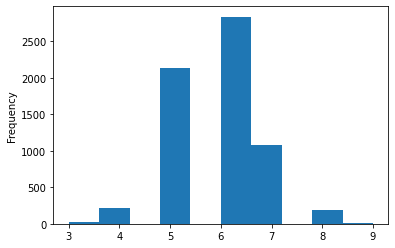

In [8]:
df_labels.plot.hist()
plt.show()



Using this information we now take a guess at what is meant by a **good** wine. At this point I'm making a decision to use the label of `5` as the cutoff for **good** vs **not-good** for the outcome of the sensory analysis by humans. Clearly this can be challenged as the idea of **good** vs **not-good** may have changed each review of the wines by each human. For example one human may feel that their scale of `8` or higher is **good** where another may feel that `3` or higher is **good**.

But for this analysis since we are splitting the data approximately in half (actually more on the **good** side vs **not bood**) we are being in some ways *generous*. But again, thats subjective interpretation of this scale as recorded in the dataset.

#### 3.1.1.4 - Converting Multi-class to Binary (two class)

This is easy enough to accomplish

In [9]:
_, df_labels = get_features_and_labels(df_all, binary=True)

rv1 = 'unique set of labels: {}'.format(np.unique(df_labels))
rv2 = 'bin count for 0-9: {}'.format(np.bincount(df_labels))

In [10]:
emit_md('> RESULT: ' + rv1)
emit_md('> RESULT: ' + rv2)

> RESULT: unique set of labels: [0 1]

> RESULT: bin count for 0-9: [2384 4113]

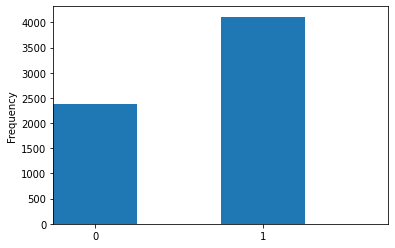

In [11]:

bins = range(0, 3)
df_labels.plot.hist(bins = bins, width = 0.5)
bins_labels(bins, shift = 0.25)
plt.show()

### 3.1.2 - Feature normalization with scaling

#### 3.1.2.1 - Training and Modeling performace

In order to improve performance of certian machine learning algorithms scaling data so that it is both consistent and within reasonable ranges can help. As articulated in [Role of Scaling in Data Classification Using SVM. 1Minaxi Arora, 2Lekha Bhambhu](http://ijarcsse.com/Before_August_2017/docs/papers/Volume_4/10_October2014/V4I10-0254.pdf)

Support Vector Machines in LIBSVM, which is what SciKit wraps, leverages a convex function (Gradient Descent or Stochastic Gradient Descent) during optimization. As pointed out in the paper, large variances in feature data can cause issues with the calculations even lengthy even perpetual lack of convergence. Convergence as it relates to Support Vector Machines is when the algorigthm has identified the hyperplane based upon the features that can separate the classes.  Later I'll cover linear separability and illustrate what that means with regards to Support Vector Machines. However, at this point be aware that the data from the Wine data set is not linear-separable. Thus the kernel to be used is [Radial Bias Function (RBF)](https://en.wikipedia.org/wiki/Radial_basis_function_kernel). This algoritm is simpler and requires only two parameters for tuning (hyperparameters) making our experimentation simpler.

From Mixaxi:
```
Main purpose of scaling data before
processing is to avoid attributes in greater numeric ranges. Other purpose is to avoid some types of numerical difficulties
during calculation. Large attribute values might cause numerical problems. Generally, scaling is performed in the range
of [-1, +1] or [0, 1].
```

For our scaling needs Scikit has [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) which happens to be  used scaler

As articulated also on the documentation for StandardScaler

```
If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.
```

There are other preprocessing approaches and classes within SciKit, such as statistical normalization. That takes the data and converts it to Z scores so the mean is always 0, and the data is somewhat normally distributed. 


#### 3.1.2.2 - Feature normalization with scaling



In [15]:
df_features, df_labels = get_features_and_labels(df_all, binary=True)

In [17]:
df_features.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


In [27]:
df_features_drop1 = df_features.drop(axis = 1, columns = ['free_sulfur_dioxide','total_sulfur_dioxide'])
df_features_drop1

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,0.99780,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,0.99680,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,0.99700,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,0.99800,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,0.99114,3.27,0.50,11.2
4894,6.6,0.32,0.36,8.0,0.047,0.99490,3.15,0.46,9.6
4895,6.5,0.24,0.19,1.2,0.041,0.99254,2.99,0.46,9.4
4896,5.5,0.29,0.30,1.1,0.022,0.98869,3.34,0.38,12.8


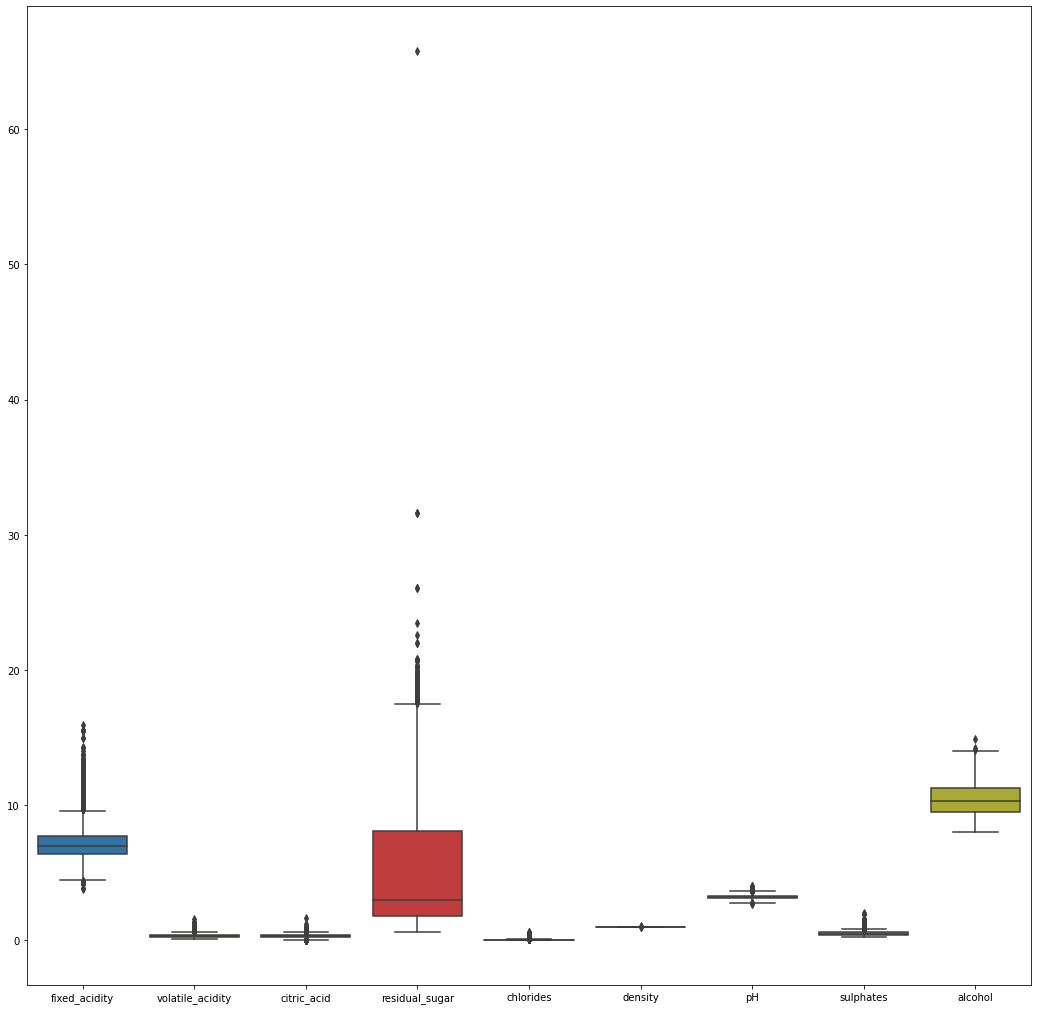

In [28]:
figsize = 18, 18
plt.figure(figsize = figsize)
sns.boxplot(data = df_features_drop1)